In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
df = pd.read_csv('dataset/ObesityDataSet.csv')
# df = df.drop(columns='id')

In [5]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [6]:
# df['Age'].describe()

In [7]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [8]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]
# WHObmi_boys

In [9]:
WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]
# WHObmi_girls

In [10]:
CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]
# CDCbmi_boys

In [11]:
CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]
# CDCbmi_girls

In [12]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [13]:
# CDCbmi_boys.loc[(CDCbmi_boys.Age - 18.128249).abs().idxmin()]

In [14]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [15]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [16]:
# df[df['Adult'] == "False"].describe()

In [17]:
# df[df['WHO BMI Predictions'] != df['CDC BMI Predictions']]

In [18]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 0.25 Mb (30.7% reduction)
memory GB:0.22
Memory reduced


features obtained


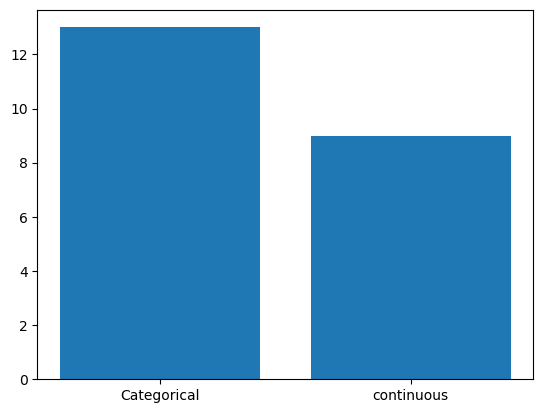

CPU times: total: 78.1 ms
Wall time: 97.1 ms


In [19]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [20]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', df_lean.shape)
# print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (df_lean.isnull().values.sum())
# test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/df_lean.shape[0]))
# print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(df_lean.info(),'\n')
# print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column #,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (2111, 22)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  13
Continuous features :  9
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-n

In [21]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [22]:
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [23]:
for cat_feat in cat_features:
    print(df[cat_feat].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']
['True' 'False']
['healthy' 'overweight' 'obseity class 1' 'N/A' 'underweight'
 'obseity class 2' 'obseity class 3']
['N/A' 'healthy' 'overweight' 'obseity class 1' 'underweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [24]:
nominal_features = [cat_features[i] for i in [0, 1, 2, 4, 5, 7, 9]]
print(nominal_features)
print()
for cat_feat in nominal_features:
    print(df[cat_feat].unique())

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS', 'Adult']

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['True' 'False']


In [25]:
ordinal_features = [cat_features[i] for i in [3, 6, 10, 11, 12]]
print(ordinal_features)
print()
for cat_feat in ordinal_features:
    print(df[cat_feat].unique())

['CAEC', 'CALC', 'Adult BMI Predictions', 'WHO BMI Predictions', 'CDC BMI Predictions']

['Sometimes' 'Frequently' 'Always' 'no']
['no' 'Sometimes' 'Frequently' 'Always']
['healthy' 'overweight' 'obseity class 1' 'N/A' 'underweight'
 'obseity class 2' 'obseity class 3']
['N/A' 'healthy' 'overweight' 'obseity class 1' 'underweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [26]:
# df

In [27]:
# X

In [28]:
# Manual encoding
manual_enc = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ]
)
    
X_enc = manual_enc.fit_transform(X, y)
# X_enc

In [29]:
# manual_enc.get_params()['ordinal'].categories

In [30]:
# X_enc.iloc[:, 9:14]

In [31]:
# X_enc.iloc[:, 15:]

In [32]:
# manual_enc.transformers

In [33]:
# manual_enc.output_indices_

In [34]:
# X

In [35]:
# Manual encoding
col_enc1 = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [36]:
col_enc2 = ColumnTransformer(
    [
        ('numerIteract', Pipeline(
            [
                ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                ('scale', StandardScaler())
            ]), slice(0, 9)),
        ('catInteract', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), slice(14, 31))
    ], verbose_feature_names_out=False
)

manual_enc2 = Pipeline([('Categorical Preprocessing', col_enc1), ('Interaction Terms', col_enc2)])
    
X_enc2 = manual_enc2.fit_transform(X.copy(), y)
# X_enc2

In [37]:
# X

In [38]:
# X_enc2.iloc[:, 3].describe()

In [39]:
# y

In [40]:
# X_enc['Gender']

In [41]:
def eval_cluster(y_true, y_pred):
    scores = [fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score]
    names = ["fowlkes_mallows_score", "homogeneity_completeness_v_measure", "adjusted_mutual_info_score", "normalized_mutual_info_score", "adjusted_rand_score", "rand_score"]
    for score, name in zip(scores, names):
        print(f"{name}: {score(y_true, y_pred)}")

In [42]:
# KM = KMeans().fit_predict(X_enc2, y)
# pd.Series(KM).describe()
# print()
# eval_cluster(KM, y)

In [43]:
# KMpp = KMeans(init='k-means++').fit_predict(X_enc2, y)
# pd.Series(KMpp).describe()
# print()
# eval_cluster(KMpp, y)

In [44]:
# GaussMix = GaussianMixture(n_components=7).fit_predict(X_enc2, y)
# pd.Series(GaussMix).describe()
# print()
# eval_cluster(GaussMix, y)

In [45]:
# BayesGaussMix = BayesianGaussianMixture(n_components=7).fit_predict(X_enc2, y)
# pd.Series(BayesGaussMix).describe()
# print()
# eval_cluster(BayesGaussMix, y)

In [46]:
# BSKM = BisectingKMeans().fit_predict(X_enc2, y)
# pd.Series(BSKM).describe()
# print()
# eval_cluster(BSKM, y)

In [47]:
## Hmm, wonder if overfitting...

In [48]:
# BSKM2 = BisectingKMeans().fit_predict(X_enc, y)
# pd.Series(BSKM2).describe()
# print()
# eval_cluster(BSKM2, y)

In [49]:
# BSKM3 = BisectingKMeans().fit_predict(OrdinalEncoder().fit_transform(X.copy(), y), y)
# pd.Series(BSKM3).describe()
# print()
# eval_cluster(BSKM3, y)

In [50]:
# BSKM4 = BisectingKMeans().fit_predict(StandardScaler().fit_transform(OrdinalEncoder().fit_transform(X.copy(), y), y), y)
# pd.Series(BSKM4).describe()
# print()
# eval_cluster(BSKM4, y)

In [51]:
# X

In [52]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [53]:
preprocessed = ['Ordinal', 'Manual Encoding', "Enc + Pairwise"]

In [54]:
X_s = [OrdinalEncoder().fit_transform(X.copy()), X_enc, X_enc2]

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=1/3, random_state=42)

In [55]:
# Model 1 - Decision Tree
test = []
models = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"Decision Tree {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Decision Tree Ordinal
training time 0.015 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.9659090909090909, AUC_ROC_OVO: 0.9799607674256328, AUC_ROC_OVR: 0.9800043245309272

Decision Tree Manual Encoding
training time 0.015 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.9644886363636364, AUC_ROC_OVO: 0.9790742426029377, AUC_ROC_OVR: 0.9791283020928913

Decision Tree Enc + Pairwise
training time 0.067 s
predict time 0.005 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.9673295454545454, AUC_ROC_OVO: 0.9809284181570715, AUC_ROC_OVR: 0.980939818121381

Best Preprocessing: Enc + Pairwise - Test Accuracy: 0.9673295454545454


In [55]:
# Model 2a - Logistic Regression
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Logistic Regression Ordinal


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


training time 12.226 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 0.8298887122416534, AUC_ROC_OVO: 0.9675872821658935, AUC_ROC_OVR: 0.9708300181562972
TEST - Accuracy: 0.8281791907514451, AUC_ROC_OVO: 0.9670783465257955, AUC_ROC_OVR: 0.9703061590913303

Logistic Regression Manual Encoding


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


training time 13.037 s
predict time 0.004 s
Confusion matrix: 
TRAIN - Accuracy: 0.8678277207688972, AUC_ROC_OVO: 0.9779857865253669, AUC_ROC_OVR: 0.9802927638081128
TEST - Accuracy: 0.8630057803468208, AUC_ROC_OVO: 0.9773942507230406, AUC_ROC_OVR: 0.9797176023214416

Logistic Regression Enc + Pairwise
training time 6.364 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.8764272293684059, AUC_ROC_OVO: 0.9803141080410617, AUC_ROC_OVR: 0.982428514881814
TEST - Accuracy: 0.867485549132948, AUC_ROC_OVO: 0.977683089209141, AUC_ROC_OVR: 0.9800117267422153

Best Preprocessing: Enc + Pairwise - Test Accuracy: 0.867485549132948


In [56]:
# Model 6a - LDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i].to_records(), y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

LDA Ordinal
training time 0.057 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 0.8200607024136436, AUC_ROC_OVO: 0.9670042185158944, AUC_ROC_OVR: 0.9707505261817377
TEST - Accuracy: 0.8236994219653179, AUC_ROC_OVO: 0.966802285185989, AUC_ROC_OVR: 0.9705597806994541

LDA Manual Encoding
training time 0.104 s
predict time 0.006 s
Confusion matrix: 
TRAIN - Accuracy: 0.8212892036421449, AUC_ROC_OVO: 0.9702588923781965, AUC_ROC_OVR: 0.9734176164249035
TEST - Accuracy: 0.8216763005780346, AUC_ROC_OVO: 0.9706266973984564, AUC_ROC_OVR: 0.9737613166978666

LDA Enc + Pairwise
training time 0.627 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.8484607602254661, AUC_ROC_OVO: 0.9744137297465839, AUC_ROC_OVR: 0.9770512060208258
TEST - Accuracy: 0.8440751445086705, AUC_ROC_OVO: 0.9732026273232917, AUC_ROC_OVR: 0.9760324500392306

Best Preprocessing: Enc + Pairwise - Test Accuracy: 0.8440751445086705


In [57]:
X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult_False,MTRANS_Motorbike Adult_True,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult_False,MTRANS_Public_Transportation Adult_True,MTRANS_Walking Adult_False,MTRANS_Walking Adult_True,Adult_False Adult_True
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0.104173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,-1.269171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,-0.991274,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,-0.477718,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,2.042301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0.395166,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,-0.993953,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,-0.403258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,1.734782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
test = X_enc.columns[0]
for name in X_enc.columns:
    print(name.split('__'))

['numerical', 'Age']
['numerical', 'Height']
['numerical', 'Weight']
['numerical', 'FCVC']
['numerical', 'NCP']
['numerical', 'CH2O']
['numerical', 'FAF']
['numerical', 'TUE']
['numerical', 'BMI']
['ordinal', 'CAEC']
['ordinal', 'CALC']
['ordinal', 'Adult BMI Predictions']
['ordinal', 'WHO BMI Predictions']
['ordinal', 'CDC BMI Predictions']
['nominal', 'Gender_Female']
['nominal', 'Gender_Male']
['nominal', 'family_history_with_overweight_no']
['nominal', 'family_history_with_overweight_yes']
['nominal', 'FAVC_no']
['nominal', 'FAVC_yes']
['nominal', 'SMOKE_no']
['nominal', 'SMOKE_yes']
['nominal', 'SCC_no']
['nominal', 'SCC_yes']
['nominal', 'MTRANS_Automobile']
['nominal', 'MTRANS_Bike']
['nominal', 'MTRANS_Motorbike']
['nominal', 'MTRANS_Public_Transportation']
['nominal', 'MTRANS_Walking']
['nominal', 'Adult_False']
['nominal', 'Adult_True']


In [59]:
X_enc2

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult_False,MTRANS_Motorbike Adult_True,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult_False,MTRANS_Public_Transportation Adult_True,MTRANS_Walking Adult_False,MTRANS_Walking Adult_True,Adult_False Adult_True
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.237862,0.104173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,-0.818331,-1.269171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-1.573741,-0.991274,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,1.753591,-0.477718,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.557096,2.042301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.227725,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,0.761393,0.395166,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20754,-1.027052,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,-1.577032,-0.993953,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20755,-0.657669,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,0.197750,-0.403258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20756,1.760067,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.161050,1.734782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
